# Сеть фитнес-центров

**Описание проекта**  
Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

**Наша задача** — провести анализ оттока клиентов и подготовить план действий по их удержанию:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
        1) выделить целевые группы клиентов;
        2) предложить меры по снижению оттока;
        3) определить другие особенности взаимодействия с клиентами.

**Результаты исследования** позволят разрабатывает стратегию взаимодействия с клиентами.

**Ход исследования**
Отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Данные получим из файла `gym.csv`.

Исследование пройдёт в четыре этапа:
 1. Изучение и обработка данных.
 2. Исследовательский анализ данных (EDA).
 3. Построение модели прогнозирования оттока клиентов.
 4. Кластеризация клиентов.

**Описание данных**     
Данные клиента за предыдущий до проверки факта оттока месяц:

    'gender' — пол;
    'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
    'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
    'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
    'Phone' — наличие контактного телефона;
    'Age' — возраст;
    'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

    'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
    'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
    'Group_visits' — факт посещения групповых занятий;
    'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
    'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
    'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
    'Churn' — факт оттока в текущем месяце.

## Изучение и обработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as st
register_matplotlib_converters()
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
sns.set_theme(
    style='whitegrid',
    rc = {'figure.figsize':(15,15)}
)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('/datasets/gym.csv')

In [3]:
def get_info(i):
    print('------ Первые 5 строк ------')
    display(i.head())
    print()
    print('------ Типы данных ------')
    i.info()
    print()
    print('------ Уникальные значения в файле ------')
    display(i.nunique())
    print()
    print('------ Пропуски в файле ------')
    display(i.isna().sum())
    print()
    print('------ Дубликаты в файле ------')
    display(i.duplicated().sum())

In [4]:
get_info(df)

------ Первые 5 строк ------


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0



------ Типы данных ------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total    

gender                                  2
Near_Location                           2
Partner                                 2
Promo_friends                           2
Phone                                   2
Contract_period                         3
Group_visits                            2
Age                                    23
Avg_additional_charges_total         4000
Month_to_end_contract                  12
Lifetime                               29
Avg_class_frequency_total            3913
Avg_class_frequency_current_month    3820
Churn                                   2
dtype: int64


------ Пропуски в файле ------


gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64


------ Дубликаты в файле ------


0

**Вывод:**
- Пропущенные значения и дубликаты отсутствуют;
- Типы данных соответствуют;
- Необходимо привести названия столбцов к нижнему регистру.

In [5]:
# приведем названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()

## Исследовательский анализ данных (EDA)

### Изучение средних значения и стандартных отклонений

In [6]:
# посмотрим на датасет
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


**Вывод:**
- примерно одинаковое распределение кллиентов по полу;
- большинство клиентов (85%) проживает или работает в районе, где находится фитнес-центр;
- почти половина клиентов (49%) являются сотрудниками компании-партнёра клуба;
- около 31% клиентов пришли в фитнес-центр в рамках акции «приведи друга»;
- мобильные телефоны указаны у 90% клиентов;
- средняя длительность абонемента - 4,68 мес., при этом медианное значение равно 1 мес. Следовательно клиенты преимущественно берут абонементы со сроком в 1 мес.;
- около 41% клиентов посещают групповые занятия;
- средний возраст клиентов - 29 лет, стандартное отклонение 3,3 года;
- средняя суммарная выручка от других услуг фитнес-центра - 147 у.е., стандартное отклонение - 96,4 у.е. (данные сильно разбросаны);
- средний срок до окончания текущего действующего абонемента - 4,3 мес., медианное значение - 1 мес.;
- среднее время с момента первого обращения в фитнес-центр - 3,7 мес., стандартное отклонение также 3,7 мес. (данные сильно разбросаны);
- средняя частота посещений за все время - 1,88 раз в неделю, стандартное отклонение - 0,97, 
- средняя частота посещений за предыдущий месяц - 1,77 раз в неделю, стандартное отклонение - 1,05, 
- отток в текущем месяце - 26,5%.

### Изучение средних значений признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [7]:
# посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался
df.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


**Вывод:**  
У оставшихся клиентов средние значения по всем признакам (кроме пола и телефона) выше чем у ушедших. В основном это клиенты которые длительное время посещают фитнес-центр (среднее время с момента первого обращения у оставшихся клиентов составляет 4,7 мес., а у ушедших - 1 мес.). Таким образом, первый месяц является критическим и в течение этого периода клиенты принимают решение оставаться или уйти.

### Построение столбчатых гистограмм и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

In [8]:
# построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)
df_left = df[df['churn']==1]
df_stayed = df[df['churn']==0]

binary_features = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

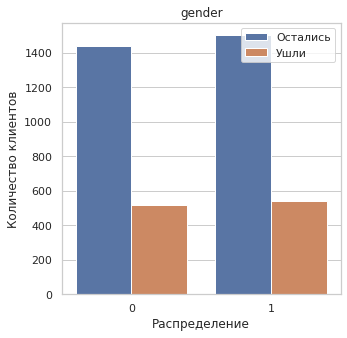

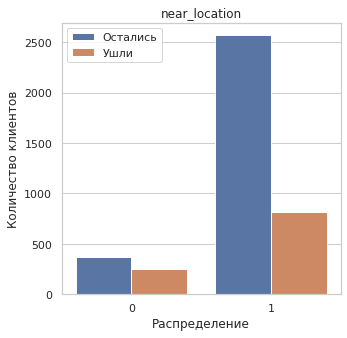

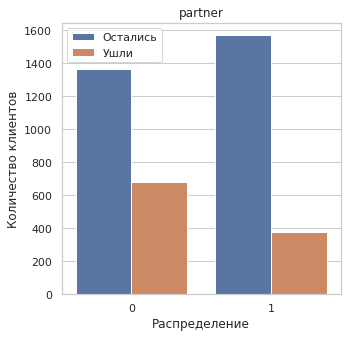

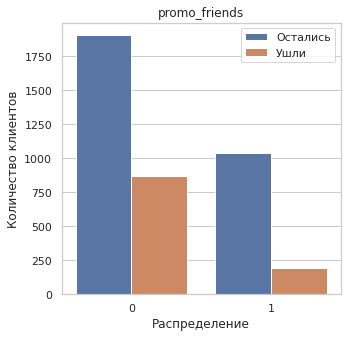

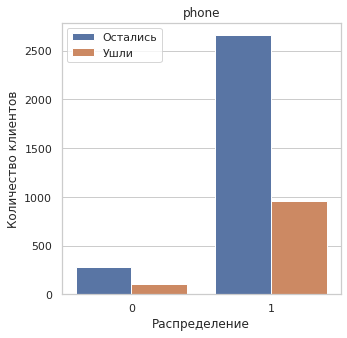

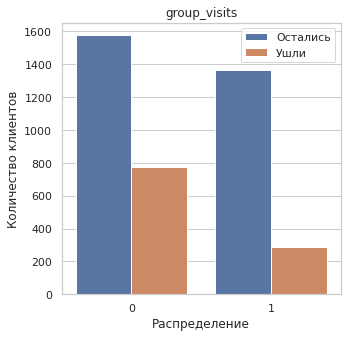

In [9]:
for column in binary_features:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = df[column], hue='churn', data=df)
    plt.title(column)
    plt.ylabel('Количество клиентов')
    plt.xlabel('Распределение')
    plt.legend(['Остались', 'Ушли'])
    plt.show()

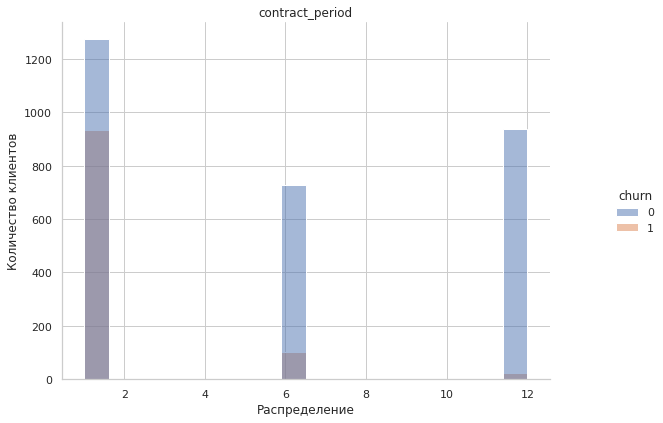

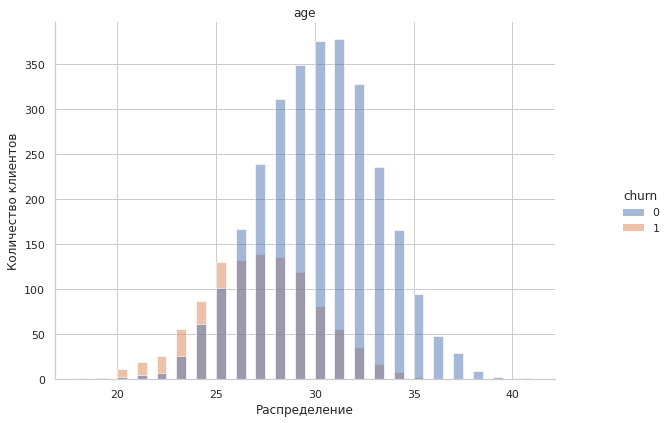

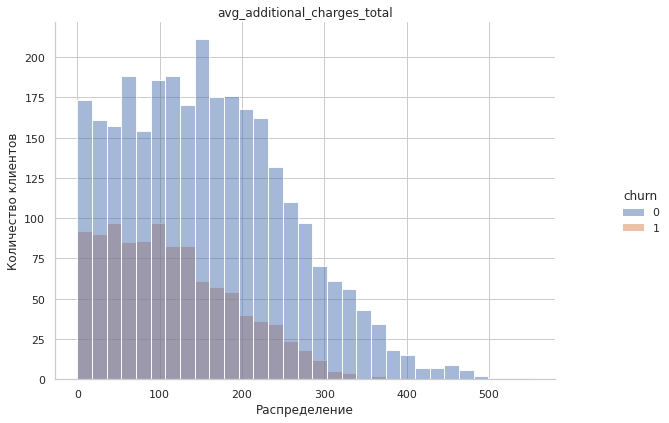

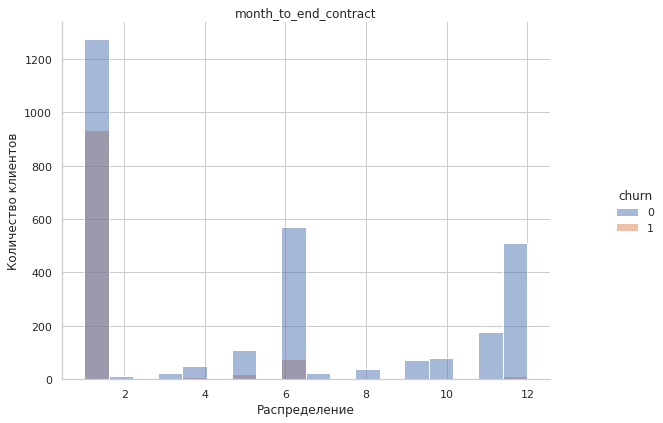

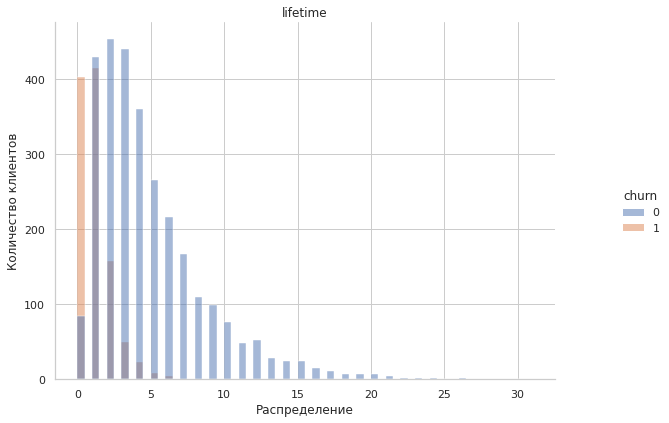

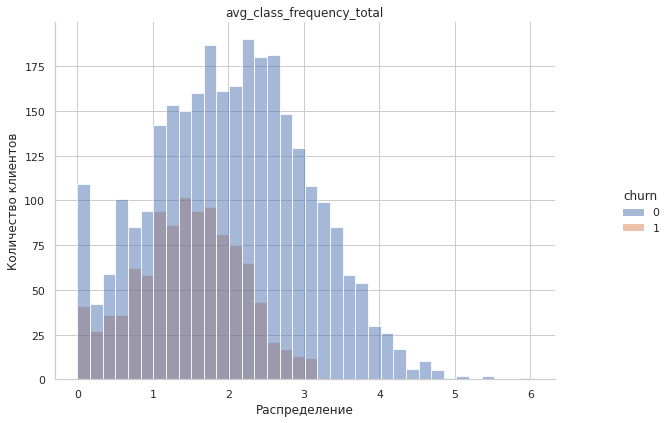

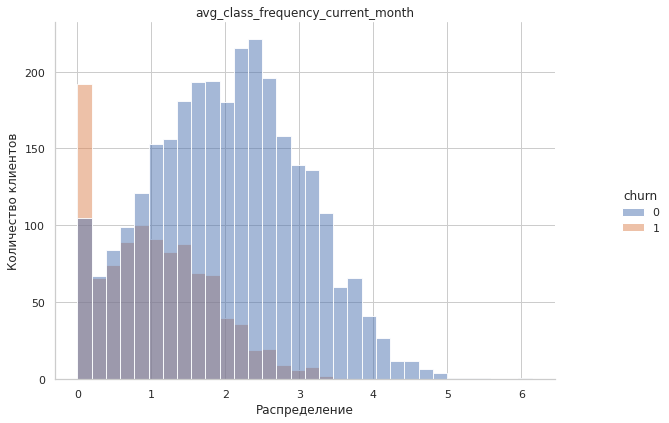

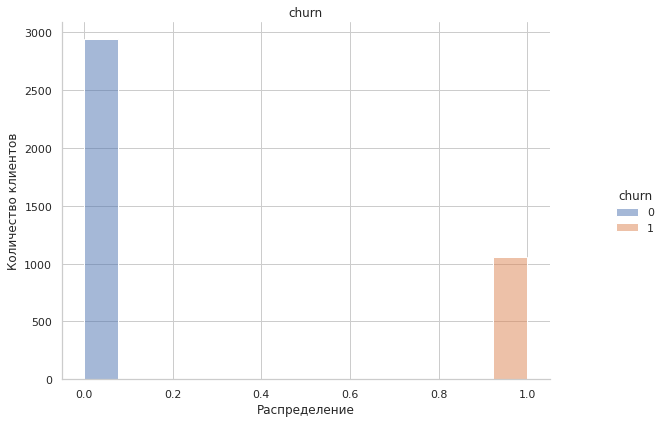

In [10]:
for column in df.columns:
    if column not in binary_features:
        ax= sns.displot(df, x=df[column], hue='churn', kind='hist')
        ax.fig.set_figwidth(10)
        ax.fig.set_figheight(6)
        plt.title(column)
        plt.ylabel('Количество клиентов')
        plt.xlabel('Распределение')
        plt.show()

**Вывод:**
- основная часть ушедших клиентов оформляют абонементы на 1 мес.;
- оставшиеся клиенты аналогично чаще берут сроки в 1 мес., но в отличие от ушедших также имеются много клиентов со сроками в 12 мес. и 6 мес.;
- возраст ушедших клиентов находится в диапазоне от 20 до 35 лет, у оставшихся - от 20 до 40 лет.

### Построение матрицы корреляций 

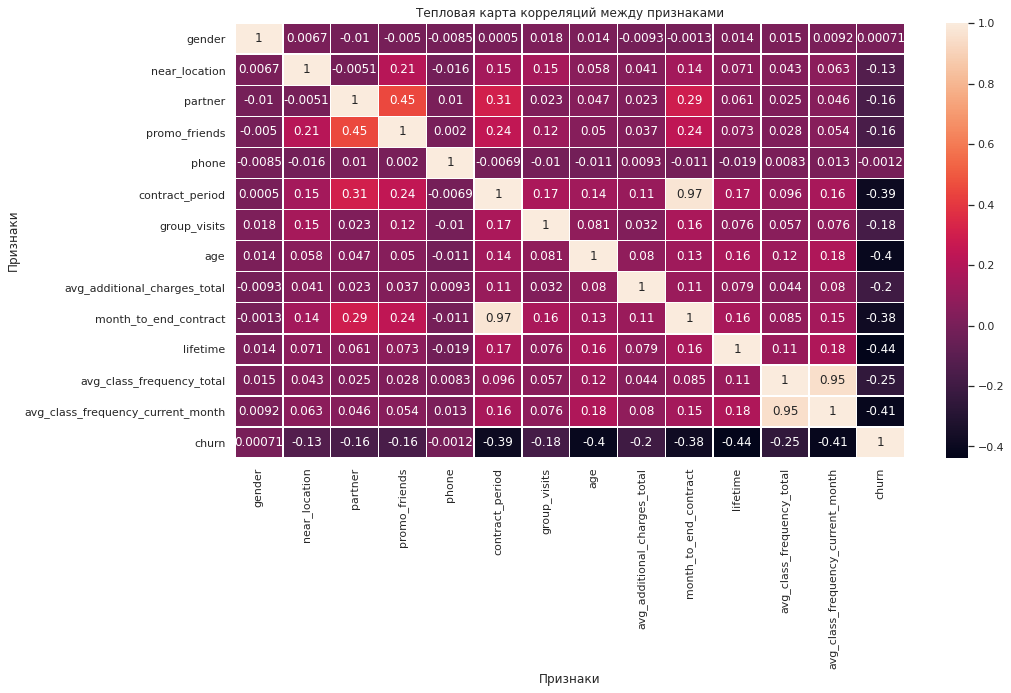

In [11]:
# построим матрицу корреляций и отобразим её
plt.subplots(figsize=(15, 8))
sns.heatmap(df.corr(), annot=True, linewidths=.5)
plt.title('Тепловая карта корреляций между признаками')
plt.ylabel('Признаки')
plt.xlabel('Признаки');

**Вывод:**
- сильная зависимость факта оттока от признаков не прослеживается;
- сильная корреляция имеется у признаков длительность и срок до окончания текущего абонемента и у признаков посещаемости за время время и за предыдущий месяц. 

Т.к. коэффициент корреляции между указанными выше признаками слишком большой (больше 0.8), чтобы не возникло проблем с линейной регрессией, для проведения дальнейшего анализа избавимся от мультиколлинеарности, удалим из датафрейма следующие признаки:
- `month_to_end_contract`;
- `avg_class_frequency_current_month`.

In [12]:
df = df.drop(['month_to_end_contract', 'avg_class_frequency_current_month', ], axis=1)

## Модель прогнозирования оттока клиентов

In [13]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis=1)
y = df['churn']

# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)  # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# применим стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

# зададим список моделей
models = [
    LogisticRegression(solver='liblinear', random_state=0),
    RandomForestClassifier(n_estimators = 100, random_state=0)
]

# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'Accuracy:{:.2f} Precision:{:.2f} Recall:{:.2f}'.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred)
        )
    )

# напишем цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)

LogisticRegression(random_state=0, solver='liblinear')
Accuracy:0.90 Precision:0.79 Recall:0.81
RandomForestClassifier(random_state=0)
Accuracy:0.89 Precision:0.79 Recall:0.76


**Вывод:**  
Согласно полученным метрикам модель "Логистической регрессии" показала себя лучше, чем модель "Случайного леса", т.к. ее метрики  "Доли правильных ответов" и "Полноты" чуть выше.

## Кластеризация клиентов

### Стандартизация данных и построение дендрограммы

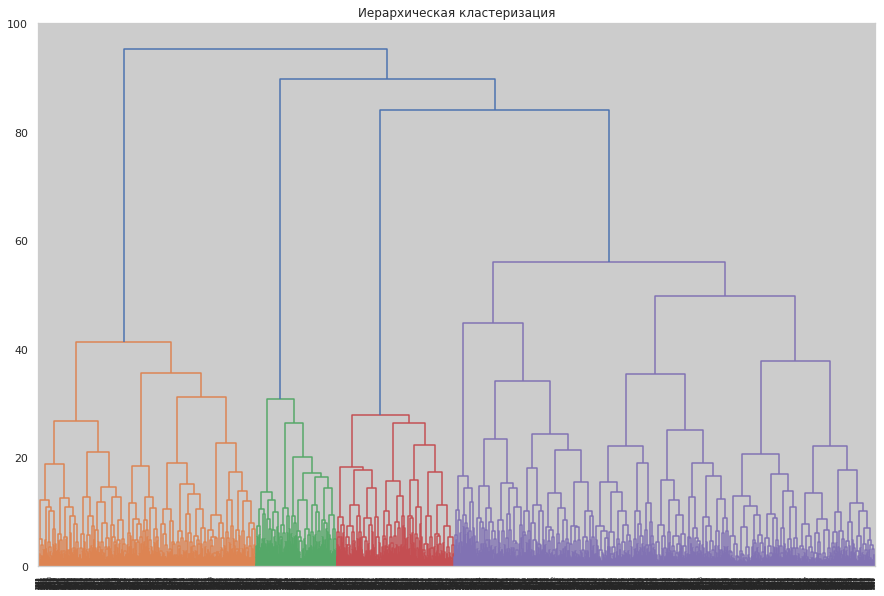

In [14]:
# стандартизируем данные
x_sc = scaler.fit_transform(X)

# построим матрицу расстояний и сохраним в переменной linked таблицу «связок» между объектами.
linked = linkage(x_sc, method = 'ward')

# визуализируем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

**Вывод:**  
Предложенное оптимальное число кластеров 4 — четыре разных цветов на графике.
Но по заданию для дальнейшего анализа используем 5 кластеров (n=5).

### Обучение модели кластеризации на основании алгоритма K-Means

In [15]:
# обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(x_sc)
# сохраняем метки кластера в поле датасета
df['cluster_km'] = labels
# выводим статистику по средним значениям наших признаков по кластеру
df.groupby('cluster_km').mean().T

cluster_km,0,1,2,3,4
gender,0.499109,0.488571,0.505300,0.544202,0.523316
near_location,0.000000,0.995238,1.000000,1.000000,0.862694
partner,0.488414,0.955238,0.238516,0.250287,0.471503
promo_friends,0.076649,0.892381,0.059187,0.079219,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,3.032086,7.660952,2.819788,4.528129,4.777202
group_visits,0.235294,0.458095,0.000000,1.000000,0.427461
age,28.721925,29.543810,28.770318,29.536165,29.297927
avg_additional_charges_total,137.540009,155.861428,143.383993,148.088897,144.208179
lifetime,3.060606,4.380952,3.343640,3.761194,3.940415


In [16]:
df['cluster_km'].value_counts()

2    1132
1    1050
3     871
0     561
4     386
Name: cluster_km, dtype: int64

Распределение количества клиентов по кластерам неравномерное.

**Отличительные признаки кластеров:**  
- **Кластер 0**:
    - живут или работают далеко от фитнес-центра;
    - самый высокий отток - 40%;
- **Кластер 1**:
    - 96% клиентов являются сотрудниками компаний-партнеров клуба;
    - 89% клиентов пришли по акции "приведи друга";
    - наиболее длительный срок абонемента - 7,7 мес.; 
    - самый низкий отток - 12%;
- **Кластер 2**:
    - ни один клиент не посещает групповые занятия;
    - высокий отток - 38%;
- **Кластер 3**:
    - все клиенты посещают групповые занятия;
- **Кластер 4**:
    - все клиенты не указали телефоны.

### Распределения признаков для кластеров

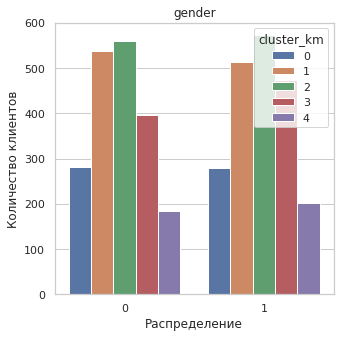

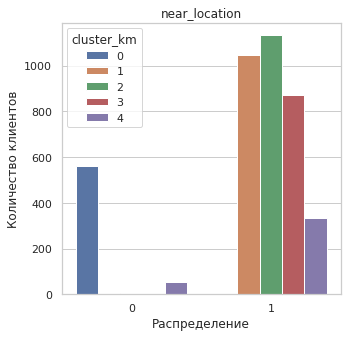

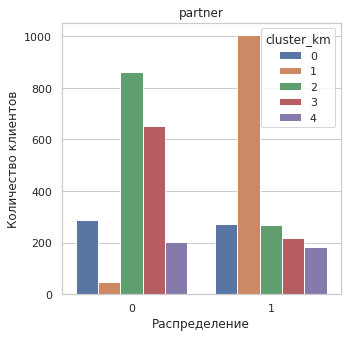

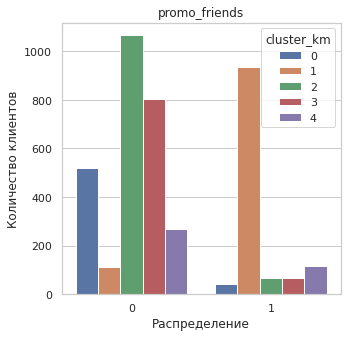

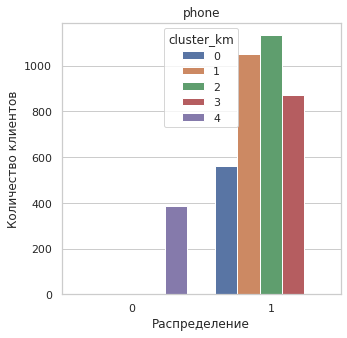

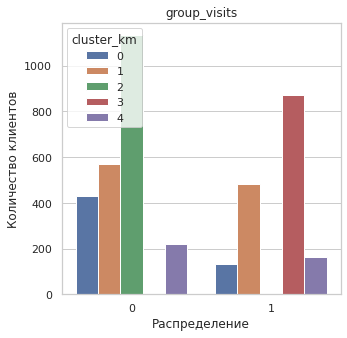

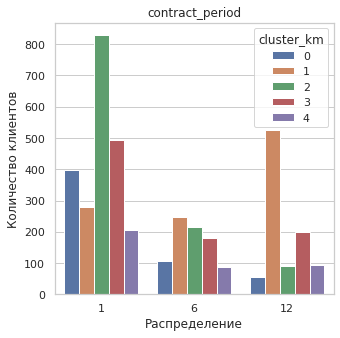

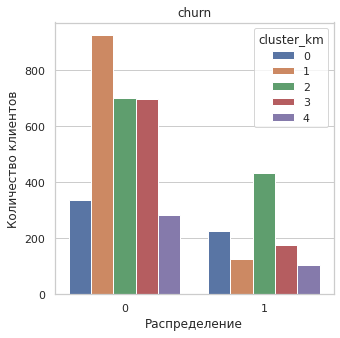

In [17]:
for column in binary_features:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = df[column], hue='cluster_km', data=df)
    plt.title(column)
    plt.ylabel('Количество клиентов')
    plt.xlabel('Распределение')
    plt.show()
    
for column in ['contract_period', 'churn']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = df[column], hue='cluster_km', data=df)
    plt.title(column)
    plt.ylabel('Количество клиентов')
    plt.xlabel('Распределение')
    plt.show()

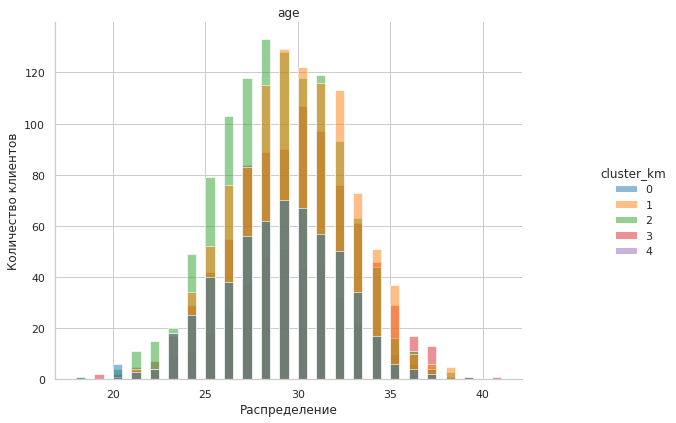

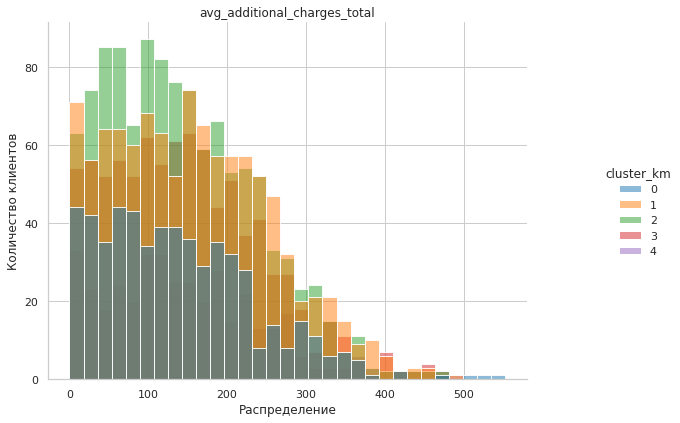

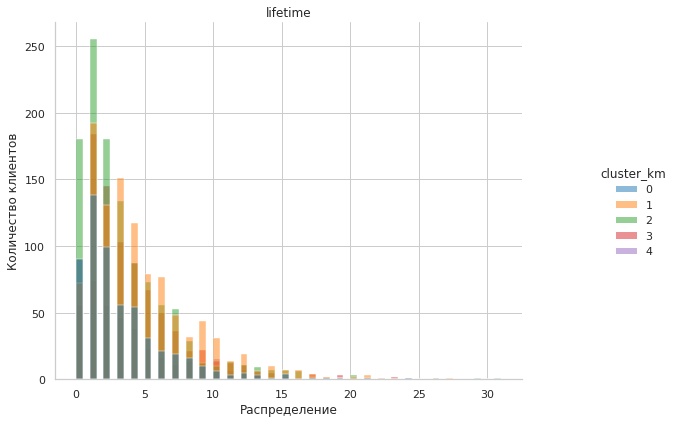

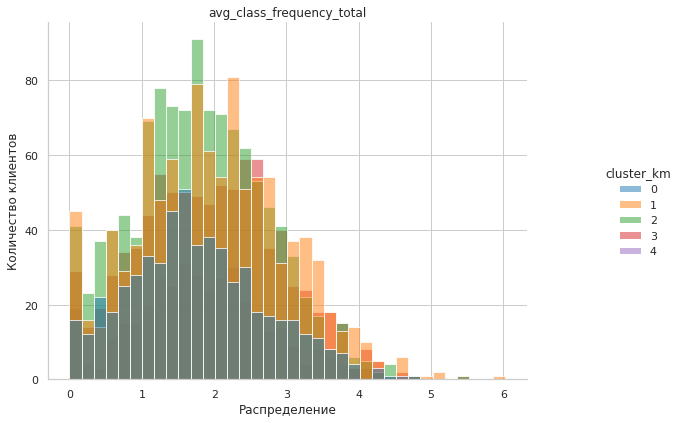

In [18]:
for column in df.columns:
    if column not in ['cluster_km', 'contract_period', 'churn']:
        if column not in binary_features:        
            ax = sns.displot(df, x=df[column], hue='cluster_km', palette='tab10', kind='hist')
            ax.fig.set_figwidth(10)
            ax.fig.set_figheight(6)
            plt.title(column)
            plt.ylabel('Количество клиентов')
            plt.xlabel('Распределение')
            plt.show()

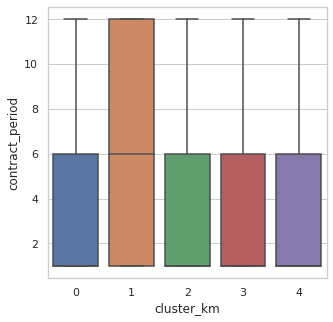

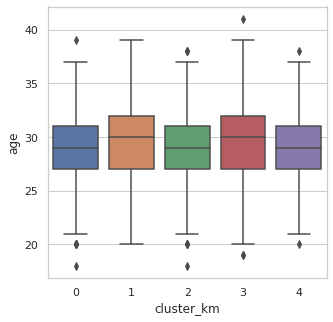

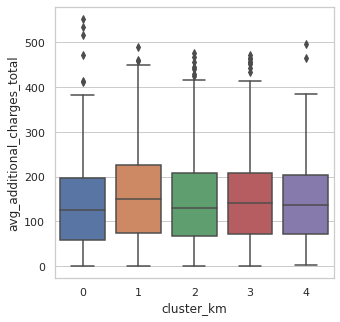

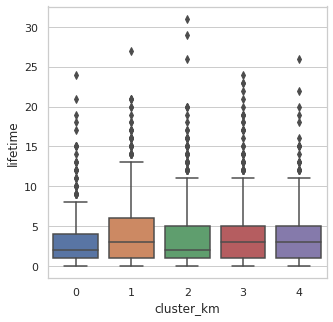

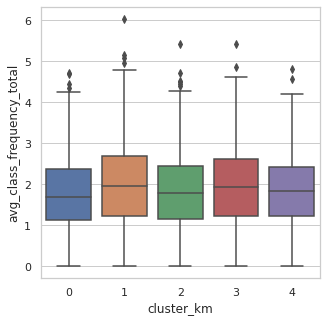

In [19]:
for column in df.columns:
    if column not in ['cluster_km', 'churn']:
        if column not in binary_features:  
            plt.figure(figsize=(5, 5))
            sns.boxplot(x = 'cluster_km', y = df[column], data = df)
            plt.show()

**Вывод:**  
- клиенты кластеров 0 и 2 с наибольщим количеством оттока - чаще оформляют абонементы на 1 мес. и по возрасту моложе остальных;
- у клиентов кластера 0  самое короткое время с момента первого обращения в фитнес-центр, чем у остальных кластеров;
- клиенты кластера 1 с наименьшим количеством оттока - чаще оформляют длительные абонементы на 12 мес., посещают зал дольше остальныхи и тратят больше денег на другие услуги.

### Расчет доли оттока для каждого полученного кластера

In [20]:
# для каждого полученного кластера посчитаем долю оттока (методом groupby()). 
df.groupby('cluster_km')['churn'].mean()

cluster_km
0    0.399287
1    0.120952
2    0.381625
3    0.200918
4    0.266839
Name: churn, dtype: float64

**Вывод:**  
Наиболее надежным является кластер 1 с наименьшей долей отток. У кластеров 0 и 2 наблюдается наибольший отток клиентов.

## Общий вывод

По итогам проведенного анализа сфорирмован профиль среднестатического клиента фитнес-клуба:
- проживает или работает в районе, где находится фитнес-центр;
- средний возраст - 29 лет.
- посещает зал 4-ый месяц по 2 раза в неделю;
- до окончания абонемента остается еще 4 месяца.

Выделены 5 кластеров клиентов, сравнительный анализ между которыми показал, что чаще всего в отток попадают клиенты, которые:
- живут или работают далеко от фитнес-центра;
- не посещают групповые занятия;
- берут абонементы на 1 мес.  

Наиболее лояльны и надежны клиенты, которые:
- являются сотрудниками компаний-партнеров клуба;
- пришли по акции "приведи друга";
- оформили длительный срок абонемента;

Таким образом, предлагаем следующие рекомендации для стратегии взаимодействия с клиентами и их удержания:
- стимулировать клиентов на покупку более длительных абонементов путем предоставления скидок или бонусов;
- мотивировать клиентов посещать групповые занятия, как вариант бесплатное пробное занятие, либо также внедрение скидок;
- можно софрмировать пакетную программу: при оформлении абонемента на длительный срок предоставлять определенное количество бесплатных посещений групповых занятий;
- продолжить взаимодействие с компаниями-партнерами клуба и действие акции "приведи друга".